# Bayesian Neural Networks (BNNs)

In this notebook a Bayesian Neural network is trained on the CFB data to take bridge parameter as input an predict the code compliance factors.

### Resources
Here you can find nice explanations: 

1. https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Bayesian_Neural_Networks/dl2_bnn_tut1_students_with_answers.html

The following source was used as a stating point for the implementation:

2. https://towardsdatascience.com/from-theory-to-practice-with-bayesian-neural-network-using-python-9262b611b825 

### Content
1. Data Import
2. Data Pre-processing
3. Setup and Train Model
4. Model Perfromance Evaluation
5. 1D Parameter Studies


In [1]:
#import necessary libraries
import json
import pandas as pd
import math as m
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
from torch.utils.data import DataLoader, TensorDataset




In [2]:
# #Filtering
# from sampler import filter_eta_range
# df_filtered=filter_eta_range(df_1003, atLeastOne_critical=False, specific_eta_critical = True, specific_eta= 'eta_min_c', critical_range=[0.1, 3], all_relevant=False, relevant_range = [0, 10])
# df_filtered[['eta_min_c','eta_min_s','eta_min_shear']]
# 1003 info: they were filtered for eta_c in 0.1 to 3 bereich
#calculated 865
# 192 =0
# 763 not 0
# davon im gewollten bereich 0.1-3: 527
# davon in bereich 0.5 bis 1.5: 197
# davon 1.5 bis 3: 266
# davon kleiner als 0.5 (>0.1)

# eta='eta_min_c'
# plt.hist(df_filtered[eta], bins =100
#          )
# plt.title(eta)


In [3]:
# # Select features
# x_names = ['L', 'b1',  't_p', 't_w', 'h_w', 'd1_plate', 'd4_plate', 'd2_plate', 's_plate', 'd1_walls', 'd4_walls', 's_walls', 'fcc', 's', 'beta', 'h_G'] # all 16 features
# # Select target(s)
# y_names=['eta_min_c', 'eta_min_s', 'eta_min_shear']

# df_1003_1=pd.read_csv('trainingData\\1003_CFB_xy_0_664.csv')
# df_1003_1=df_1003_1[x_names+y_names]
# df_1003_1

# df_1003_2=pd.read_csv('trainingData\\1003_CFB_xy_800_999.csv')
# df_1003_2=df_1003_2[x_names+y_names]
# df_1003_2

# df_save=pd.concat([df_1003_1, df_1003_2], ignore_index=True)
# df_save
# df_save.to_csv('trainingData\\1003_CFB_xy_wo_665_to_799.csv')
# df_save

In [4]:
# df_1003=pd.read_csv('trainingData\\RawData\\1003_CFB_xy.csv')
# # Select features
# x_names = ['L', 'b1',  't_p', 't_w', 'h_w', 'd1_plate', 'd4_plate', 'd2_plate', 's_plate', 'd1_walls', 'd4_walls', 's_walls', 'fcc', 's', 'beta', 'h_G'] # all 16 features
# # Select target(s)
# y_names=['eta_min_c', 'eta_min_s', 'eta_min_shear']

# df_1003=df_1003[x_names+y_names]


# df_train=pd.read_csv('trainingData\\1001_1002_CFB_xy_train.csv')
# df_train=df_train[x_names+y_names]


# df_save=pd.concat([df_train, df_1003], ignore_index=True)
# df_save=df_save[df_save['eta_min_c']!=0]
# #df_save.to_csv('trainingData\\1001_1002_1003_CFB_xy_train.csv')
# df_save
# # df_1003[df_1003['eta_min_c']!=0]



In [6]:
## Initialise Training study tracking dict
# initialise whole dict (only run once per study)
# only has to be run once when a new dict should be created
dict_name='Test'
eval_dict={}

In [6]:
# import json

# # Load the two dictionaries from the JSON files
# with open('trainedModels\\Studie_1_Sophia.json') as f1, open('trainedModels\\Study_0_Antoine.json') as f2:
#     dict_Sophia = json.load(f1)
#     dict_Antoine = json.load(f2)

# # Combine the two dictionaries with updated key naming
# combined_dict = {}

# # Append '_S' to all keys from Sophia's study
# for key in dict_Sophia:
#     combined_dict[key + '_S'] = dict_Sophia[key]

# # Append '_A' to all keys from Antoine's study
# for key in dict_Antoine:
#     combined_dict[key + '_A'] = dict_Antoine[key]

# # Save the combined dictionary back to a JSON file if needed
# with open('trainedModels\\Combined_Study.json', 'w') as out_file:
#     json.dump(combined_dict, out_file, indent=4)

# # Optional print of the combined dictionary for review
# print(json.dumps(combined_dict, indent=4))

In [7]:
# load_evaluation dict

dict_name='Advanced_Study'
with open('trainedModels\\{}.json'.format(dict_name), 'r') as file:
    eval_dict = json.load(file)

In [44]:
# Initialize an empty list to hold the rows
rows = []

# Initialize an empty list to hold the column headers
columns = []

# Loop through the nested dictionary to build rows and columns
for key, subdict in eval_dict.items():
    row = {}
    for subkey, subsubdict in subdict.items():
        for subsubkey, value in subsubdict.items():
            column = (subkey, subsubkey)  # subkey and subsubkey as the column header
            row[column] = value
            if column not in columns:
                columns.append(column)  # Collect all unique columns
    rows.append((key, row))

# Create a DataFrame with the columns and rows, using the key as the index
df = pd.DataFrame([row for _, row in rows], index=[key for key, _ in rows])

# Set multi-level columns (subkey, subsubkey)
df.columns = pd.MultiIndex.from_tuples(columns)

# Display the DataFrame
df.to_excel("trainedModels/{}.xlsx".format(dict_name))

## 1.  Data Import 

Data is imported from the defined csv file to a pandas Data Frame.

In [2]:
####### load values #######

data_batch='1001_1002_1003'
train_df = pd.read_csv("trainingData/1001_1002_1003_CFB_xy_train.csv")
val_df = pd.read_csv("trainingData/1001_CFB_xy_validation.csv")
test_df = pd.read_csv("trainingData/1001_CFB_xy_test.csv")




In [3]:
train_df

,Unnamed: 0,L,b1,t_p,t_w,h_w,d1_plate,d4_plate,d2_plate,s_plate,d1_walls,d4_walls,s_walls,fcc,s,beta,h_G,eta_min_c,eta_min_s,eta_min_shear
0,0,7316.767442,9858.693527,670.111910,296.960109,4578.954788,19.123075,23.414408,29.351365,437.575707,14.570059,20.392475,329.743669,26.216140,0.841518,-0.899371,763.083525,0.971350,0.999918,0.255641
1,1,4109.497290,10040.817949,216.866461,627.347199,2757.955442,25.327086,13.852833,28.445230,376.195192,22.440791,14.785867,156.659807,45.467104,0.357328,-17.686199,480.888478,2.988712,0.999900,0.478011
2,2,6481.214774,19642.425351,630.452453,808.700433,3575.074819,20.018548,15.454918,20.991629,235.775667,17.670412,20.880608,159.539665,31.003168,0.588936,47.460891,300.381370,14.358522,2.190585,2.100074
3,3,4983.830508,5045.232703,813.243489,281.592574,3852.597077,25.990575,13.490555,19.389877,179.930373,10.911357,23.134080,229.052153,49.855574,0.615093,0.413577,671.177680,3.832633,1.029085,0.178855
4,4,11350.654319,14992.112972,915.516826,996.779574,2742.346227,24.762013,25.404220,18.919854,404.169200,16.415385,12.309846,236.947986,39.761843,0.666640,13.325371,575.321280,7.989916,1.485492,0.950330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6385,6838,7292.481726,2630.929558,500.384132,365.346225,2099.483844,22.511029,23.139504,22.873908,144.227288,11.349843,19.782584,346.978847,34.589178,0.835711,-27.874869,520.826358,2.171281,1.011887,0.433113
6386,6840,8094.059731,12028.432802,360.563532,683.659168,2651.087277,26.445904,11.030083,25.111461,261.108592,16.060830,26.952644,435.715078,49.261283,0.104358,45.371711,944.729841,1.787798,0.998492,0.117897
6387,6841,6867.661205,19716.650866,236.612677,1231.230380,4223.863628,14.351139,26.322388,19.703159,503.726652,20.077918,23.156073,437.503691,43.620750,0.652775,11.149412,769.333947,0.906973,0.999184,0.139870
6388,6842,10821.158745,2459.541545,505.002233,376.288504,4798.753440,29.130015,17.164455,24.657522,262.883424,21.006850,27.708275,82.557592,30.096884,0.450170,24.083232,1080.477264,1.615063,0.998288,0.068358


In [7]:


# Select features
x_names = ['L', 'b1',  't_p', 't_w', 'h_w', 'd1_plate', 'd4_plate', 'd2_plate', 's_plate', 'd1_walls', 'd4_walls', 's_walls', 'fcc', 's', 'beta', 'h_G'] # all 16 features
# Select target(s)
y_names=['eta_min_c']

x_train_df = train_df[x_names]
y_train_df = train_df[y_names]
x_val_df = val_df[x_names]
y_val_df = val_df[y_names]
x_test_df = test_df[x_names]
y_test_df = test_df[y_names]

# transfrom to numpy arrays
x_train_np = x_train_df.values
y_train_np = y_train_df.values
x_val_np = x_val_df.values
y_val_np = y_val_df.values
x_test_np = x_test_df.values
y_test_np = y_test_df.values

#Print shapes of the splitted data sets
print('Training Dataset: ',x_train_df.shape,y_train_df.shape )
print('Validation Dataset: ',x_val_df.shape, y_val_df.shape)
print('Test Dataset: ',x_test_df.shape,y_test_df.shape)



####### needed for the scaler #######
x_data_df = pd.concat([x_train_df, x_val_df, x_test_df], axis=0, ignore_index=True)
print('Total Dataset: ',x_data_df.shape )
total_data_set_size=x_data_df.shape[0]

Training Dataset:  (6390, 16) (6390, 1)
Validation Dataset:  (962, 16) (962, 1)
Test Dataset:  (1202, 16) (1202, 1)
Total Dataset:  (8554, 16)


## 2. Pre-process Data

Pre-Processing Steps
- select x and y columns (inputs and outputs)
- split data set in trianing and test set
- transform data to same range with MinMaxScaler
- transform scaled data to troch tensors

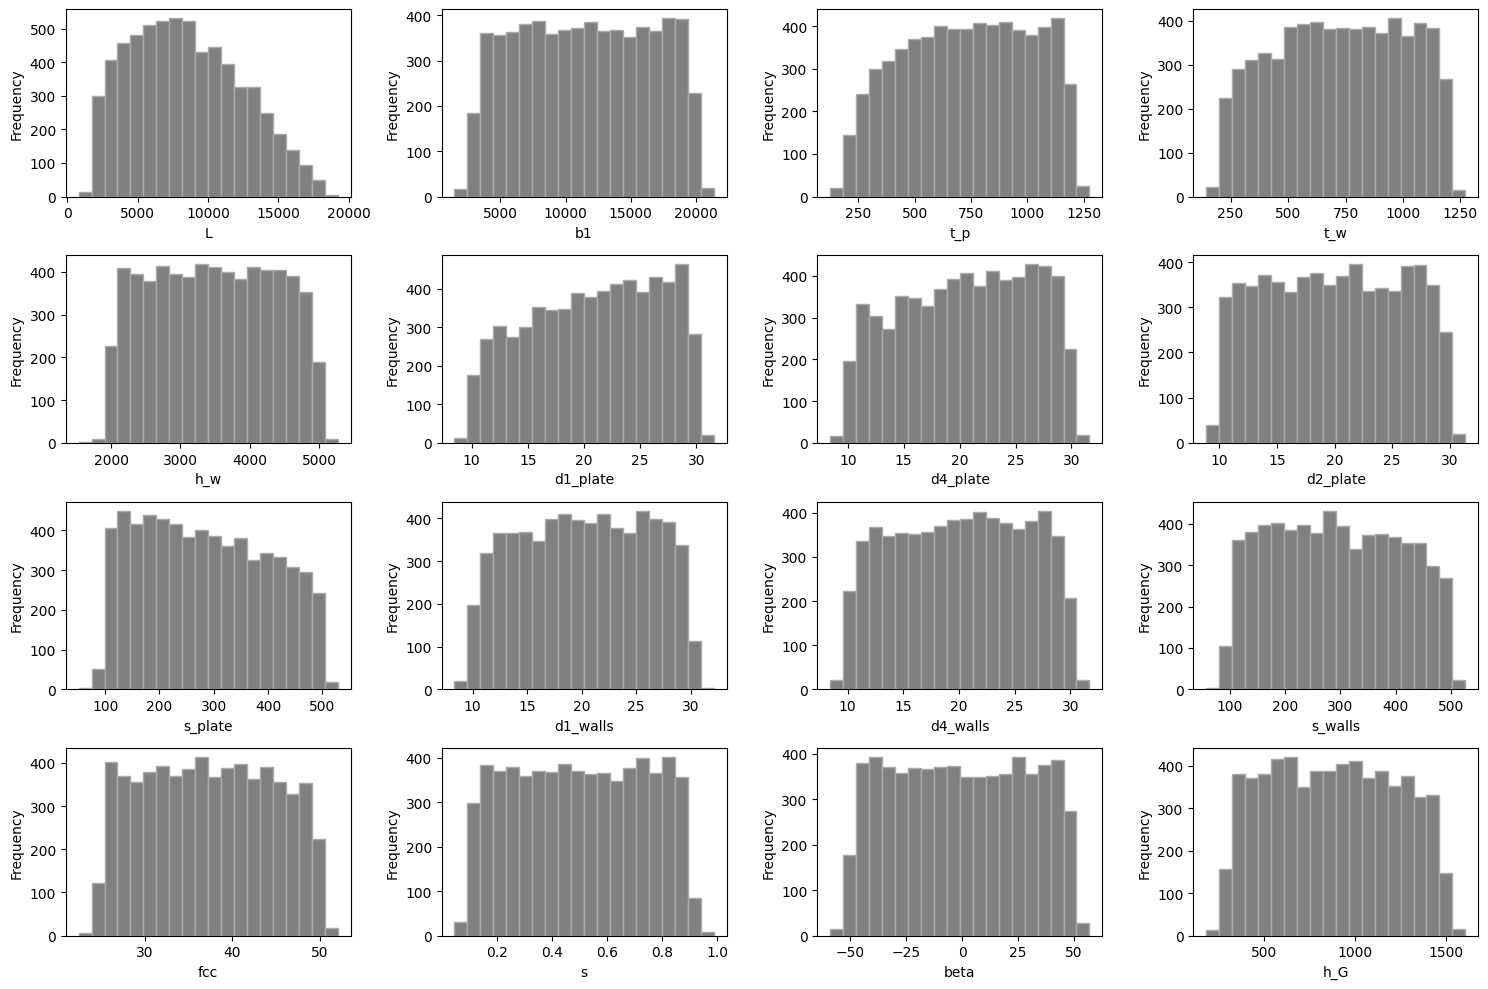

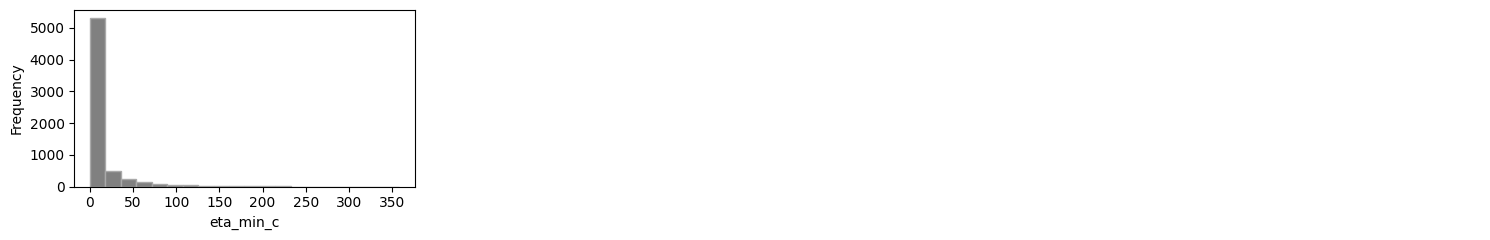

In [8]:
from plotting import hist_matrix
hist_matrix(x_train_df)
hist_matrix(y_train_df)

In [9]:
###### Scaling of data ######

# INPUT we scale to a range 0,1
# Initialize the MinMaxScaler and fit it on the training data
# Note: MinMaxScaler  scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.
# Note: MinMaxScaler doesn’t reduce the effect of outliers, but it linearly scales them down into a fixed range
# Note: MinMaxScaler is sufficient as our data is uniformily distributed for the case when we have non-uniform distirbuted data (as sampled with )

#initialize scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# fit scaler on total data set
scaler.fit(x_data_df)

# scale training data
x_train_scaled_np = scaler.transform(x_train_df)
x_train_scaled_df=pd.DataFrame(data=x_train_scaled_np, columns=scaler.get_feature_names_out())

# Scale the validation data using the same scaler
x_val_scaled_np = scaler.transform(x_val_df)
x_val_scaled_df=pd.DataFrame(data=x_val_scaled_np, columns=scaler.get_feature_names_out())

# Scale the validation data using the same scaler
x_test_scaled_np = scaler.transform(x_test_df)
x_test_scaled_df=pd.DataFrame(data=x_test_scaled_np, columns=scaler.get_feature_names_out())

#plot scaled data
x_train_scaled_df.describe()

,L,b1,t_p,t_w,h_w,d1_plate,d4_plate,d2_plate,s_plate,d1_walls,d4_walls,s_walls,fcc,s,beta,h_G
count,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000
mean,0.415495,0.506200,0.529696,0.516522,0.520477,0.538362,0.523458,0.495844,0.488939,0.499127,0.505126,0.502811,0.502508,0.484397,0.506549,0.492128
std,0.211955,0.249206,0.241755,0.247641,0.231385,0.246179,0.246705,0.257305,0.241203,0.240128,0.247971,0.243358,0.243815,0.248703,0.253079,0.240827
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.243588,0.291906,0.332464,0.314526,0.320308,0.336437,0.317310,0.273541,0.281327,0.295519,0.293597,0.294216,0.293180,0.269763,0.287704,0.284334
50%,0.397301,0.505760,0.537985,0.521730,0.518824,0.554046,0.534811,0.496987,0.474742,0.501949,0.511408,0.494456,0.498634,0.482650,0.502191,0.493189
75%,0.570802,0.723482,0.736202,0.728013,0.719774,0.752311,0.735745,0.722166,0.691609,0.707330,0.717054,0.708527,0.710452,0.701978,0.727111,0.693674
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
# Note instead of scaling the data here I inlcuded a mean squared log error loss in my training which has the same effect but no need for preprocessing and postprocing of training input and prediction output
# ###### Scaling of data ######

# # Y (Output) we scale with log(y)
# #m.log(y_train_np)

# # Applying y_trans=log_e(y+1) function/ transformation
# y_train_transf_np = np.log(y_train_np + 1) # log_e
# y_train_transf_df=pd.DataFrame(y_train_transf_np, columns=y_names)

# y_val_transf_np = np.log(y_val_np + 1) # log_e
# y_val_transf_df=pd.DataFrame(y_val_transf_np, columns=y_names)


# hist_matrix(y_train_transf_df)


# ##### convert to troch tensors ######

# # convert data to toch tensors (as needed format for BNN model)
# x_train_scaled_tensor=torch.tensor(x_train_scaled_df.values, dtype=torch.float32)
# y_train_transf_tensor=torch.tensor(y_train_transf_df.values, dtype=torch.float32)

# x_val_scaled_tensor=torch.tensor(x_val_scaled_df.values, dtype=torch.float32)
# y_val_transf_tensor=torch.tensor(y_val_transf_df.values, dtype=torch.float32)

In [11]:
##### convert to troch tensors ######

# convert data to toch tensors (as needed format for BNN model)
#training data
x_train_scaled_tensor=torch.tensor(x_train_scaled_df.values, dtype=torch.float32)
y_train_tensor=torch.tensor(y_train_df.values, dtype=torch.float32)

#validation data
x_val_scaled_tensor=torch.tensor(x_val_scaled_df.values, dtype=torch.float32)
y_val_tensor=torch.tensor(y_val_df.values, dtype=torch.float32)

#test data
x_test_scaled_tensor=torch.tensor(x_test_scaled_df.values, dtype=torch.float32)
y_test_tensor=torch.tensor(y_test_df.values, dtype=torch.float32)


## 3. Setup and Train Model

- Define NN Architecture
- Define Losses
- Trianing Loop
- Plot loss developement during trianing
- save trained model

In [30]:
# define NN architecture
width=[16,20,20] # define manually #20,20,20
layers=len(width)
# define manually 
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=16, out_features=20),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=20, out_features=20),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=20, out_features=1),
    nn.ReLU()
)

# model = nn.Sequential(
#     bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=16, out_features=20),
#     nn.ReLU(),
#     bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=20, out_features=20),
#     nn.ReLU(),
#     bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=20, out_features=20),
#     nn.ReLU(),
#     bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=20, out_features=20),
#     nn.ReLU(),
#     bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=20, out_features=20),
#     nn.ReLU(),
#     bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=20, out_features=1),
#     nn.ReLU()
# )


#initialize error tracking lists
mse_list=[]
mse_val_list=[]

msle_list=[]
msle_val_list=[]

mean_mse_list=[]
mean_mse_val_list=[]

weighted_mse_list = []
weighted_mse_val_list = []

rmse_list=[]
rmse_val_list=[]

kl_list=[]
kl_val_list=[]

mape_list=[]
mape_val_list=[]

custom_loss_list = []
custom_loss_val_list = []

#initialize stochastic error tracking lists


In [31]:
##### Losses ######

#get loss functions
# get kl loss
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
# get mse loss
mse_loss = nn.MSELoss()

#import losses
from MLmodel import  weighted_mse_loss, msle_loss, mape_loss,custom_loss





In [32]:
### Define other hyperparameters

# define kl weight for weighing of kl_loss in total loss function
# Note: depending which loss function are used different kl_weights should be chosen...msle is of a multiple magnitude smaller than the mse, so the kl_weight hast to also be adapter when we use that weight.
# Note: with mse loss 0.01, with msle loss 0.0001 [0.001]
#TO Test: [0.01,0.001, 0.0001]
kl_weight = 0.001

#get optimizer
learning_rate=0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# define epochs, and the training data, and the batch size
epochs = 10
batch_size = 32

#loss function hyperparameters for weighted mse loss
wMSE_loss_importance_range=(0.1,2)
wMSE_loss_high_weight=1000


In [33]:
### save model training settings to eval_dict

#define model name:
# name rule: batch_filter_modeldepth_width_lossfunction_epochs_iteration
#!!!!
model_name='Test_2'  # define manually

# # initialize model dict
# if model_name in eval_dict:
#     raise ValueError(f"Error: The model name '{model_name}' already exists. Please use a different name to prevent overwriting.")
# else:
#     eval_dict[model_name] = {}
eval_dict[model_name] = {}
eval_dict[model_name]['model_settings']={}
eval_dict[model_name]['training_set_performance']={}
eval_dict[model_name]['validation_set_performance']={}

# save model settings
eval_dict[model_name]['model_settings']['batch']=data_batch
eval_dict[model_name]['model_settings']['filtered']="without zero etas" 
eval_dict[model_name]['model_settings']['total_data_size']=total_data_set_size
eval_dict[model_name]['model_settings']['test_split']=0.2 
eval_dict[model_name]['model_settings']['val_split']=0.2 
eval_dict[model_name]['model_settings']['layers']=layers
eval_dict[model_name]['model_settings']['width']=width
#!!!!
eval_dict[model_name]['model_settings']['loss']=['rmse', 'weighted mse'] # define manually
eval_dict[model_name]['model_settings']['wMSE_loss_importance_range']=wMSE_loss_importance_range
eval_dict[model_name]['model_settings']['wMSE_loss_high_weight']=wMSE_loss_high_weight


eval_dict[model_name]['model_settings']['kl_weight']=kl_weight
eval_dict[model_name]['model_settings']['learning_rate']=[0.001,0.001]#learning_rate
eval_dict[model_name]['model_settings']['epochs']=[400,300]#epochs
eval_dict[model_name]['model_settings']['batch_size']=batch_size

#print
eval_dict[model_name]

{'model_settings': {'batch': '1001_1002_1003',
  'filtered': 'without zero etas',
  'total_data_size': 8554,
  'test_split': 0.2,
  'val_split': 0.2,
  'layers': 3,
  'width': [16, 20, 20],
  'loss': ['rmse', 'weighted mse'],
  'wMSE_loss_importance_range': (0.1, 2),
  'wMSE_loss_high_weight': 1000,
  'kl_weight': 0.001,
  'learning_rate': [0.001, 0.001],
  'epochs': [400, 300],
  'batch_size': 32},
 'training_set_performance': {},
 'validation_set_performance': {}}

In [48]:
### trianing loop 
from MLmodel import bnn_predict_with_uncertainty

# Shuffle is set to True to randomize the order of training data at each epoch
train_dataset = TensorDataset(x_train_scaled_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# x = x_train_scaled_tensor
# y = y_train_transf_tensor
with_stochasticPrediction=False

#training loop
for step in range(epochs):
    
    model.train()

    epoch_mse = []
    epoch_msle = []
    epoch_weighted_mse = []
    epoch_rmse = []
    epoch_kl = []
    epoch_mape = []
    epoch_custom = []

    for x, y in train_loader:
        y_pred = model(x)

        if with_stochasticPrediction:
            y_pred_mean_np, y_pred_std_np, y_pred_n_times=bnn_predict_with_uncertainty(model, x, n=100)
            y_pred_mean_tensor=torch.tensor(y_pred_mean_np, dtype=torch.float32)
            mean_mse = mse_loss(y_pred_mean_tensor, y)
            mean_mse_list.append(mean_mse.item())
            
        #standard mse, rmse loss
        mse = mse_loss(y_pred, y)
        epoch_mse.append(mse.item())
        # mse_list.append(mse.item())
        rmse = torch.sqrt(mse)
        epoch_rmse.append(rmse.item())

        #msle loss
        msle = msle_loss(y_pred, y,base='10')
        epoch_msle.append(msle.item())
        # msle_list.append(msle.item())

        # weighted MSE loss
        weighted_mse = weighted_mse_loss(y_pred, y, importance_range=wMSE_loss_importance_range, high_weight=wMSE_loss_high_weight)
        epoch_weighted_mse.append(weighted_mse.item())
        # custom_mse_list.append(custom_mse.item())

        # mape
        mape= mape_loss(y_pred, y)
        epoch_mape.append(mape.item())


        # # Custom loss
        custom = custom_loss(y_pred, y, threshold=0.5, alpha=1, beta=1)
        epoch_custom.append(custom.item())

        #kl_divergence loss
        kl = kl_loss(model)
        epoch_kl.append(kl.item())
        # kl_list.append(kl.item())

        # Add individual losses weighted to single loss
        cost = rmse + kl_weight*kl
        cost_log=msle + kl_weight*kl
        cost_weigthed_mse= weighted_mse + kl_weight*kl
        cost_mape = mape + kl_weight*kl
        cost_custom=custom + kl_weight*kl
        
        optimizer.zero_grad()
        #!!!!
        cost_weigthed_mse.backward() #Specify loss that should be used here
        #!!!!
        optimizer.step()

    # Calculate mean losses for the epoch (on training data) and save in loss lists
    mse_list.append(np.mean(epoch_mse))
    rmse_list.append(np.mean(epoch_rmse))
    msle_list.append(np.mean(epoch_msle))
    weighted_mse_list.append(np.mean(epoch_weighted_mse))
    kl_list.append(np.mean(epoch_kl))
    mape_list.append(np.mean(epoch_mape))
    custom_loss_list.append(np.mean(epoch_custom))

    # Calculate validation loss calculation and save in loss tracking lists
    model.eval()
    with torch.no_grad():
        y_val_pred = model(x_val_scaled_tensor)

        #standard mse, rmse loss
        mse_val = mse_loss(y_val_pred, y_val_tensor)
        mse_val_list.append(mse_val.item())
        rmse_val = torch.sqrt(mse_val)
        rmse_val_list.append(rmse_val.item())

        #msle los
        msle_val = msle_loss(y_val_pred, y_val_tensor, base='10')
        msle_val_list.append(msle_val.item())

        # weighted MSE loss
        weighted_mse_val = weighted_mse_loss(y_val_pred, y_val_tensor, importance_range=(0, 4), high_weight=10)
        weighted_mse_val_list.append(weighted_mse_val.item())

        # mape loss
        mape_val = mape_loss(y_val_pred, y_val_tensor)
        mape_val_list.append(mape_val.item())

        # custom loss
        custom_val = custom_loss(y_val_pred, y_val_tensor, threshold=0.5, alpha=1, beta=1)
        custom_loss_val_list.append(custom_val.item())
        

    # verbalise
    if step % 50 == 0:
        if with_stochasticPrediction:
            print(f'Step {step}, On Training Set: MSE: {mse.item():.2f}, Mean MSE: {mean_mse.item():.2f}, MSLE: {msle.item():.2f}, KL: {kl.item():.2f}, RMSE: {rmse.item():.2f}, '
                f'Weighted MSE: {weighted_mse.item():.2f}, MAPE: {mape.item():.2f}, Custom Loss: {custom.item():.2f}; '
                'On Validation Set:', f'Val MSE: {mse_val.item():.2f}, Val MSLE: {msle_val.item():.2f}, Val RMSE: {rmse_val.item():.2f}, Val Weighted MSE: {weighted_mse_val.item():.2f}, '
                f'Val MAPE: {mape_val.item():.2f}, Val Custom Loss: {custom_val.item():.2f}')
        else:
            print(f'Step {step}, On Training Set: MSE: {mse.item():.2f}, MSLE: {msle.item():.2f}, KL: {kl.item():.2f}, RMSE: {rmse.item():.2f}, '
                f'Weighted MSE: {weighted_mse.item():.2f}, MAPE: {mape.item():.2f}, Custom Loss: {custom.item():.2f}; '
                'On Validation Set:', f'Val MSE: {mse_val.item():.2f}, Val MSLE: {msle_val.item():.2f}, Val RMSE: {rmse_val.item():.2f}, Val Weighted MSE: {weighted_mse_val.item():.2f}, '
                f'Val MAPE: {mape_val.item():.2f}, Val Custom Loss: {custom_val.item():.2f}')


# OLD
#     # verbalise
#     if step % 50 == 0:
#         if with_stochasticPrediction:
#             print(f'Step {step}, On Training Set: MSE: {mse.item():.2f}, Mean MSE: {mean_mse.item():.2f}, MSLE: {msle.item():.2f}, KL: {kl.item():.2f}, RMSE: {rmse.item():.2f}, '
#                 f'Weighted MSE: {weighted_mse.item():.2f}, MAPE: {mape.item():.2f}, Custom Loss: {custom.item():.2f}; '
#                 'On Validation Set:', f'Val MSE: {mse_val.item():.2f}, Val MSLE: {msle_val.item():.2f}, Val RMSE: {rmse_val.item():.2f}, Val Weighted MSE: {weighted_mse_val.item():.2f}, '
#                 f'Val MAPE: {mape_val.item():.2f}, Val Custom Loss: {custom_val.item():.2f}')
#         else: 
#             print(f'Step {step}, On Training Set: MSE: {mse.item():.2f}, MSLE: {msle.item():.2f}, KL: {kl.item():.2f}, RMSE: {rmse.item():.2f}, '
#                 f'Weighted MSE: {weighted_mse.item():.2f}, MAPE: {mape.item():.2f}, Custom Loss: {custom.item():.2f}; '
#                 'On Validation Set:', f'Val MSE: {mse_val.item():.2f}, Val MSLE: {msle_val.item():.2f}, Val RMSE: {rmse_val.item():.2f}, Val Weighted MSE: {weighted_mse_val.item():.2f}, '
#                 f'Val MAPE: {mape_val.item():.2f}, Val Custom Loss: {custom_val.item():.2f}')

    

print('Training is finished. The final losses:') 
if with_stochasticPrediction:
    print(f'Step {step}, On Training Set: MSE: {mse.item():.2f}, Mean MSE: {mean_mse.item():.2f}, MSLE: {msle.item():.2f}, KL: {kl.item():.2f}, RMSE: {rmse.item():.2f}, '
          f'Weighted MSE: {weighted_mse.item():.2f}, MAPE: {mape.item():.2f}, Custom Loss: {custom.item():.2f}, '
          'On Validation Set:', f'Val MSE: {mse_val.item():.2f}, Val MSLE: {msle_val.item():.2f}, Val RMSE: {rmse_val.item():.2f}, Val Weighted MSE: {weighted_mse_val.item():.2f}, '
          f'Val MAPE: {mape_val.item():.2f}, Val Custom Loss: {custom_val.item():.2f}')
else:
    print(f'Step {step}, On Training Set: MSE: {mse.item():.2f}, MSLE: {msle.item():.2f}, KL: {kl.item():.2f}, RMSE: {rmse.item():.2f}, '
          f'Weighted MSE: {weighted_mse.item():.2f}, MAPE: {mape.item():.2f}, Custom Loss: {custom.item():.2f}, '
          'On Validation Set:', f'Val MSE: {mse_val.item():.2f}, Val MSLE: {msle_val.item():.2f}, Val RMSE: {rmse_val.item():.2f}, Val Weighted MSE: {weighted_mse_val.item():.2f}, '
          f'Val MAPE: {mape_val.item():.2f}, Val Custom Loss: {custom_val.item():.2f}')   


# print('Training is finished. The final losses:') 
# if with_stochasticPrediction:
#     print(f'Step {step}, On Training Set: MSE: {mse.item():.2f}, Mean MSE: {mean_mse.item():.2f}, MSLE: {msle.item():.2f}, KL: {kl.item():.2f}, RMSE: {rmse.item():.2f}, '
#           f'Weighted MSE: {weighted_mse.item():.2f}, MAPE: {mape.item():.2f}, Custom Loss: {custom.item():.2f}, '
#           'On Validation Set:', f'Val MSE: {mse_val.item():.2f}, Val MSLE: {msle_val.item():.2f}, Val RMSE: {rmse_val.item():.2f}, Val Weighted MSE: {weighted_mse_val.item():.2f}, '
#           f'Val MAPE: {mape_val.item():.2f}, Val Custom Loss: {custom_val.item():.2f}')
# else:
#     print(f'Step {step}, On Training Set: MSE: {mse.item():.2f}, MSLE: {msle.item():.2f}, KL: {kl.item():.2f}, RMSE: {rmse.item():.2f}, '
#           f'Weighted MSE: {weighted_mse.item():.2f}, MAPE: {mape.item():.2f}, Custom Loss: {custom.item():.2f}, '
#           'On Validation Set:', f'Val MSE: {mse_val.item():.2f}, Val MSLE: {msle_val.item():.2f}, Val RMSE: {rmse_val.item():.2f}, Val Weighted MSE: {weighted_mse_val.item():.2f}, '
#           f'Val MAPE: {mape_val.item():.2f}, Val Custom Loss: {custom_val.item():.2f}')

Step 0, On Training Set: MSE: 158.83, MSLE: 0.28, KL: 12.83, RMSE: 12.60, Weighted MSE: 251.52, MAPE: 76.29, Custom Loss: 0.69; On Validation Set: Val MSE: 335.20, Val MSLE: 0.23, Val RMSE: 18.31, Val Weighted MSE: 340.11, Val MAPE: 99.14, Val Custom Loss: 0.66
Training is finished. The final losses:
Step 9, On Training Set: MSE: 124.47, MSLE: 0.11, KL: 13.70, RMSE: 11.16, Weighted MSE: 180.63, MAPE: 66.59, Custom Loss: 0.54, On Validation Set: Val MSE: 288.72, Val MSLE: 0.23, Val RMSE: 16.99, Val Weighted MSE: 294.53, Val MAPE: 96.39, Val Custom Loss: 0.68


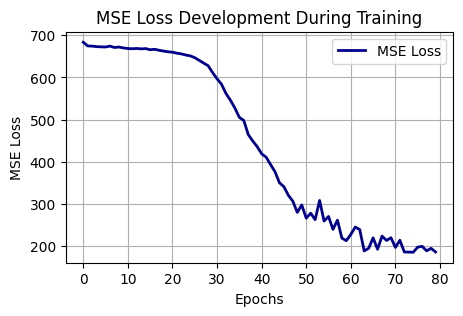

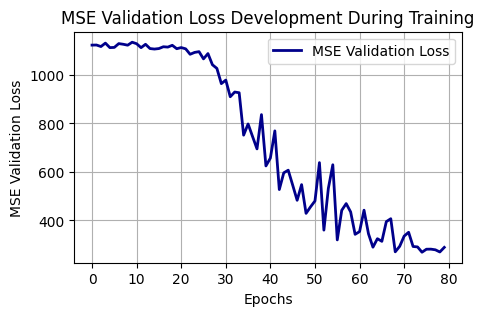

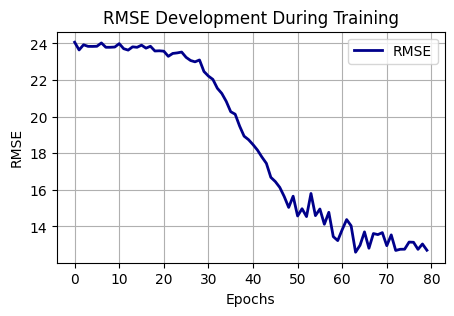

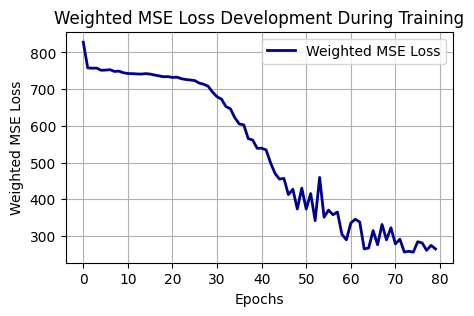

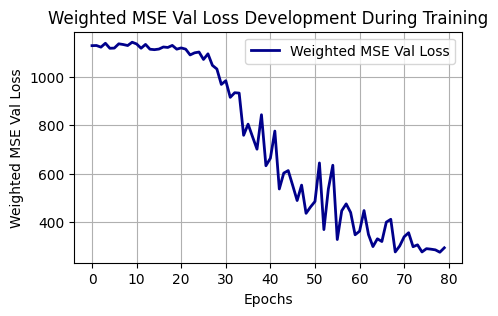

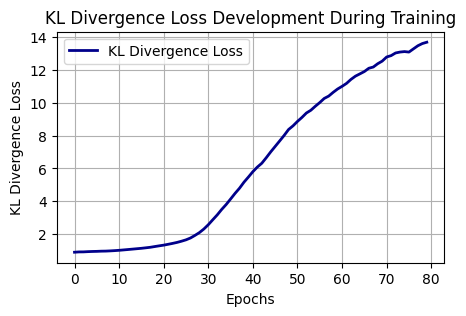

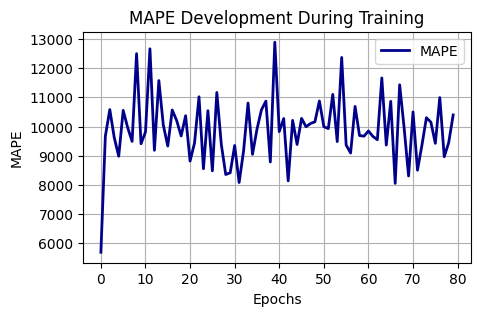

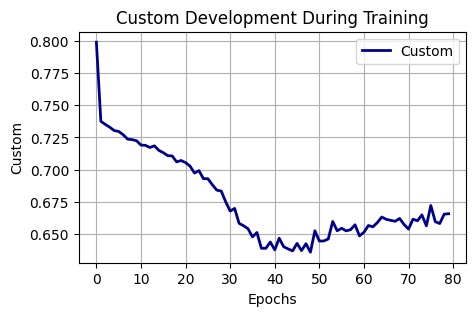

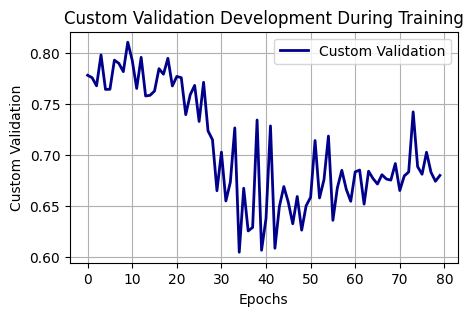

In [49]:
from plotting import plot_loss_development

loss_lists = [mse_list, mse_val_list, rmse_list, weighted_mse_list,weighted_mse_val_list, kl_list, mape_list, custom_loss_list,custom_loss_val_list]
# loss_lists = [mse_list, mean_mse_list, kl_list, rmse_list, weighted_mse_list]
loss_names = ['MSE Loss', 'MSE Validation Loss', 'RMSE', 'Weighted MSE Loss','Weighted MSE Val Loss', 'KL Divergence Loss', 'MAPE', 'Custom', 'Custom Validation']
# loss_names = ['MSE Loss', 'Mean MSE Loss', 'KL Divergence Loss', 'RMSE', 'Custom MSE Loss']

# Define a path to save the plots, if needed
save_path = 'trainedModels' # Example path, change it as needed

plot_loss_development(loss_lists, loss_names, save_path, color='darkblue', model_name=model_name, figsize=(5, 3))

In [53]:
# ####### save model #######
# # define model name

# #saving the whole model
# torch.save(model, 'trainedModels\\'+model_name+'.pth')

# #saving just the weights and biases
# #torch.save(model.state_dict(), 'trainedModels\\'+name_training_run+'.pth')

## 4. Model evaluation
    


In [54]:
## load a model
# model_name='1001_1002_1003_no0_3_20_rmse_weighted_mse_400_300_1'
model = torch.load('trainedModels\\'+model_name+'.pth')

model.eval() # sets the model to evaluation mode, which affects layers like dropout and batch normalization that behave differently during training and inference.
model

FileNotFoundError: [Errno 2] No such file or directory: 'trainedModels\\1001_1002_1003_no0_3_20_rmse_weighted_mse_400_300_1.pth'

In [33]:
from plotting import plot_true_vs_pred, single_para_strudy_perf
from MLmodel import bnn_predict_with_uncertainty, calculate_rmse, filter_values_within_range, calculate_mape, calculate_custom_loss, evaluate_model_performance

### On training data



In [58]:
# make predictions and caluclate mean 
##### make predictions ####3
# Define number of predictions
n_predictions = 1000
# Perfrom multiple predictions on data --> get mean and std for each data point
y_train_mean_pred_np, y_train_std_pred_np, y_train_pred_n_times = bnn_predict_with_uncertainty(model, x_train_scaled_tensor, n=n_predictions, log_transform_back=False)

In [59]:
sub_dict_name='training_set_performance'
eval_dict=evaluate_model_performance(y_true=y_train_np, y_pred=y_train_mean_pred_np,
                                      dict_name=sub_dict_name, model_name=model_name, eval_dict=eval_dict)

In [60]:
# uncertanty evaluation

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

#y_pred_mean=
#y_pred_std


# Define a range of confidence levels
confidence_levels = np.linspace(0, 1, 100)
coverages = []

# Compute prediction intervals (e.g., 95% confidence intervals) (Assumption that the predictive distribution is a normal dirtsibution)
for confidence_level in confidence_levels:
    z = norm.ppf((1 + confidence_level) / 2)  # z-score for the confidence level
    prediction_intervals = np.array([
        [meanPred - z * std, meanPred + z * std]
        for meanPred, std in zip(y_train_mean_pred_np, y_train_std_pred_np)
    ])

    # Check if actual values fall within prediction intervals
    within_intervals = np.array([
        interval[0] <= y_true <= interval[1]
        for interval, y_true in zip(prediction_intervals, y_train_np)
    ])
    
    # Proportion of times actual values fall within prediction intervals
    coverage = np.mean(within_intervals)
    coverages.append(coverage)

#print(coverages)

from sklearn.metrics import mean_squared_error
# Calculate Expected Calibration Error (ECE)
ece = np.mean(np.abs(confidence_levels - coverages))
#print("Expected Calibration Error (ECE):", ece)

# Calculate Total Calibration Error (TCE)
tce = np.sum(np.abs(confidence_levels - coverages))
# print("Total Calibration Error (TCE):", tce)

# Calculate Bias (Positive for Overconfidence, Negative for Underconfidence)
bias = np.sum(confidence_levels - coverages)
# print("Calibration Bias:", bias)

# safe to dict
eval_dict[model_name][sub_dict_name]['ECE']=ece
eval_dict[model_name][sub_dict_name]['TCE']=tce
eval_dict[model_name][sub_dict_name]['CB']=bias

In [61]:
#print perfromances on training set
eval_dict[model_name][sub_dict_name]

{'rmse_all': 25.883529353310852,
 'mape_all': 10752.431445290089,
 'rmse_crit1': 0.32873146382668067,
 'mape_crit1': 33.700012804371546,
 'rmse_crit2': 1.0984790426075426,
 'mape_crit2': 43.38549237815869,
 'rmse_crit3': 4.855040424888147,
 'mape_crit3': 75.48180208555134,
 'rmse_crit4': 48.60652886856595,
 'mape_crit4': 93.84535254323774,
 'custom': 0.7139853095539039,
 'ECE': 0.45456494522691715,
 'TCE': 45.45649452269171,
 'CB': 45.45649452269171}

### on validation set

In [38]:
##### make predictions ####
# Define number of predictions
n_predictions = 1000

# Perfrom multiple predictions on data --> get mean and std for each data point
y_val_mean_pred_np, y_val_std_pred_np, y_val_pred_n_times = bnn_predict_with_uncertainty(model, x_val_scaled_tensor, n=n_predictions,log_transform_back=False)


In [39]:
sub_dict_name='validation_set_performance'
eval_dict=evaluate_model_performance(y_true=y_val_np, y_pred=y_val_mean_pred_np,
                                      dict_name=sub_dict_name, model_name=model_name, eval_dict=eval_dict)

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


# Define a range of confidence levels
confidence_levels = np.linspace(0, 1, 100)
coverages = []

# Compute prediction intervals (e.g., 95% confidence intervals) (Assumption that the predictive distribution is a normal dirtsibution)
for confidence_level in confidence_levels:
    z = norm.ppf((1 + confidence_level) / 2)  # z-score for the confidence level
    prediction_intervals = np.array([
        [meanPred - z * std, meanPred + z * std]
        for meanPred, std in zip(y_val_mean_pred_np, y_val_std_pred_np)
    ])

    # Check if actual values fall within prediction intervals
    within_intervals = np.array([
        interval[0] <= y_true <= interval[1]
        for interval, y_true in zip(prediction_intervals, y_val_np)
    ])
    
    # Proportion of times actual values fall within prediction intervals
    coverage = np.mean(within_intervals)
    coverages.append(coverage)

print(coverages)


# Calculate Expected Calibration Error (ECE)
ece = np.mean(np.abs(confidence_levels - coverages))
print("Expected Calibration Error (ECE):", ece)

# Calculate Total Calibration Error (TCE)
tce = np.sum(np.abs(confidence_levels - coverages))
print("Total Calibration Error (TCE):", tce)

# Calculate Bias (Positive for Overconfidence, Negative for Underconfidence)
bias = np.sum(confidence_levels - coverages)
print("Calibration Bias:", bias)

# safe to dict
eval_dict[model_name][sub_dict_name]['ECE']=ece
eval_dict[model_name][sub_dict_name]['TCE']=tce
eval_dict[model_name][sub_dict_name]['CB']=bias

[0.0, 0.002079002079002079, 0.0031185031185031187, 0.0031185031185031187, 0.007276507276507277, 0.007276507276507277, 0.008316008316008316, 0.008316008316008316, 0.009355509355509356, 0.009355509355509356, 0.009355509355509356, 0.011434511434511435, 0.011434511434511435, 0.011434511434511435, 0.013513513513513514, 0.015592515592515593, 0.017671517671517672, 0.018711018711018712, 0.01975051975051975, 0.02079002079002079, 0.02182952182952183, 0.02182952182952183, 0.02182952182952183, 0.02182952182952183, 0.02286902286902287, 0.02286902286902287, 0.02598752598752599, 0.02702702702702703, 0.028066528066528068, 0.028066528066528068, 0.029106029106029108, 0.031185031185031187, 0.033264033264033266, 0.033264033264033266, 0.033264033264033266, 0.033264033264033266, 0.035343035343035345, 0.036382536382536385, 0.036382536382536385, 0.037422037422037424, 0.038461538461538464, 0.0395010395010395, 0.04054054054054054, 0.04261954261954262, 0.04781704781704782, 0.04781704781704782, 0.0478170478170478

In [41]:
#print perfromances on validation set
eval_dict[model_name][sub_dict_name]

{'rmse_all': 5.893030103201533,
 'mape_all': 49.37591853020605,
 'rmse_crit1': 0.6179203651819913,
 'mape_crit1': 41.92794548580791,
 'rmse_crit2': 1.2300663913569092,
 'mape_crit2': 41.84538192873229,
 'rmse_crit3': 2.642404435776211,
 'mape_crit3': 39.460480543038656,
 'rmse_crit4': 8.762856000071094,
 'mape_crit4': 14.20059241322832,
 'custom': 0.3023148785452515,
 'ECE': 0.4284407484407485,
 'TCE': 42.84407484407485,
 'CB': 42.84407484407485}

# Svaing Eval Dict

In [42]:
import json

#naming
#dict_name='Studie_1_Sophia'
# dict_name='Combined_Study'

# Saving the dictionary to a JSON file
with open('trainedModels\\{}.json'.format(dict_name), 'w') as file:
    json.dump(eval_dict, file, indent=4)